# Objective
Use training and test data provided to predict Premium Amount for each row in the test data.

# Dataset Description
Data was generated from a deep learning model trained on another Kaggle insurance dataset (link on competition data page). Fearutre distributions are close to, but not exactly the same as the original dataset. Can use the original dataset in addition to this default dataset to explore differences and experiment with model performance between default and combined data.

train.csv
- Training dataset
- Premium Amount = continuous target

test.csv
- Test dataset
- Objective is to predict Premium Amount for each row

sample_submission.csv
- Sample submission in correct format

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/playground-series-s4e12/sample_submission.csv
/kaggle/input/playground-series-s4e12/train.csv
/kaggle/input/playground-series-s4e12/test.csv


# Import Libraries

In [2]:
# Ignore deprication warnings throughout notebook
import warnings
warnings.filterwarnings('ignore') 

pd.set_option('display.max_columns', None)

In [3]:
import time
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, OrdinalEncoder, StandardScaler
from sklearn.impute import KNNImputer

# Exploratory Data Analysis

First, I want to gain a basic understanding of the training and test data that I have been provided and ensure that there are no major differences between the two that might affect my work/approach. For example, if some columns are present in the training data, but missing from the test data, I would not want to build a model that relies on those missing features.

I will explore the following topics initially:
* Size and shape of data
* data types
* summary stats
* Missing value/null value counts and handling
* Outliers
* Duplicate handling
* Formatting consistency
* comparison of the above between training and test datasets

## Read in the data

In [4]:
train_full = pd.read_csv('/kaggle/input/playground-series-s4e12/train.csv')
test_full = pd.read_csv('/kaggle/input/playground-series-s4e12/test.csv')

In [5]:
train_full.head()

,id,Age,Gender,Annual Income,Marital Status,Number of Dependents,Education Level,Occupation,Health Score,Location,Policy Type,Previous Claims,Vehicle Age,Credit Score,Insurance Duration,Policy Start Date,Customer Feedback,Smoking Status,Exercise Frequency,Property Type,Premium Amount
0,0,19.0,Female,10049.0,Married,1.0,Bachelor's,Self-Employed,22.598761,Urban,Premium,2.0,17.0,372.0,5.0,2023-12-23 15:21:39.134960,Poor,No,Weekly,House,2869.0
1,1,39.0,Female,31678.0,Divorced,3.0,Master's,NaN,15.569731,Rural,Comprehensive,1.0,12.0,694.0,2.0,2023-06-12 15:21:39.111551,Average,Yes,Monthly,House,1483.0
2,2,23.0,Male,25602.0,Divorced,3.0,High School,Self-Employed,47.177549,Suburban,Premium,1.0,14.0,NaN,3.0,2023-09-30 15:21:39.221386,Good,Yes,Weekly,House,567.0
3,3,21.0,Male,141855.0,Married,2.0,Bachelor's,NaN,10.938144,Rural,Basic,1.0,0.0,367.0,1.0,2024-06-12 15:21:39.226954,Poor,Yes,Daily,Apartment,765.0
4,4,21.0,Male,39651.0,Single,1.0,Bachelor's,Self-Employed,20.376094,Rural,Premium,0.0,8.0,598.0,4.0,2021-12-01 15:21:39.252145,Poor,Yes,Weekly,House,2022.0


In [6]:
test_full.head()

,id,Age,Gender,Annual Income,Marital Status,Number of Dependents,Education Level,Occupation,Health Score,Location,Policy Type,Previous Claims,Vehicle Age,Credit Score,Insurance Duration,Policy Start Date,Customer Feedback,Smoking Status,Exercise Frequency,Property Type
0,1200000,28.0,Female,2310.0,NaN,4.0,Bachelor's,Self-Employed,7.657981,Rural,Basic,NaN,19.0,NaN,1.0,2023-06-04 15:21:39.245086,Poor,Yes,Weekly,House
1,1200001,31.0,Female,126031.0,Married,2.0,Master's,Self-Employed,13.381379,Suburban,Premium,NaN,14.0,372.0,8.0,2024-04-22 15:21:39.224915,Good,Yes,Rarely,Apartment
2,1200002,47.0,Female,17092.0,Divorced,0.0,PhD,Unemployed,24.354527,Urban,Comprehensive,NaN,16.0,819.0,9.0,2023-04-05 15:21:39.134960,Average,Yes,Monthly,Condo
3,1200003,28.0,Female,30424.0,Divorced,3.0,PhD,Self-Employed,5.136225,Suburban,Comprehensive,1.0,3.0,770.0,5.0,2023-10-25 15:21:39.134960,Poor,Yes,Daily,House
4,1200004,24.0,Male,10863.0,Divorced,2.0,High School,Unemployed,11.844155,Suburban,Premium,NaN,14.0,755.0,7.0,2021-11-26 15:21:39.259788,Average,No,Weekly,House


## Size and Shape

In [7]:
print('The training data contains', train_full.shape[0], 'rows and', train_full.shape[1], 'columns.')

The training data contains 1200000 rows and 21 columns.


In [8]:
print('The test data contains', test_full.shape[0], 'rows and', test_full.shape[1], 'columns.')

The test data contains 800000 rows and 20 columns.


## Datatypes

In [9]:
train_full.dtypes

id                        int64
Age                     float64
Gender                   object
Annual Income           float64
Marital Status           object
Number of Dependents    float64
Education Level          object
Occupation               object
Health Score            float64
Location                 object
Policy Type              object
Previous Claims         float64
Vehicle Age             float64
Credit Score            float64
Insurance Duration      float64
Policy Start Date        object
Customer Feedback        object
Smoking Status           object
Exercise Frequency       object
Property Type            object
Premium Amount          float64
dtype: object

In [10]:
test_full.dtypes

id                        int64
Age                     float64
Gender                   object
Annual Income           float64
Marital Status           object
Number of Dependents    float64
Education Level          object
Occupation               object
Health Score            float64
Location                 object
Policy Type              object
Previous Claims         float64
Vehicle Age             float64
Credit Score            float64
Insurance Duration      float64
Policy Start Date        object
Customer Feedback        object
Smoking Status           object
Exercise Frequency       object
Property Type            object
dtype: object

In [11]:
train_full.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1200000 entries, 0 to 1199999
Data columns (total 21 columns):
 #   Column                Non-Null Count    Dtype  
---  ------                --------------    -----  
 0   id                    1200000 non-null  int64  
 1   Age                   1181295 non-null  float64
 2   Gender                1200000 non-null  object 
 3   Annual Income         1155051 non-null  float64
 4   Marital Status        1181471 non-null  object 
 5   Number of Dependents  1090328 non-null  float64
 6   Education Level       1200000 non-null  object 
 7   Occupation            841925 non-null   object 
 8   Health Score          1125924 non-null  float64
 9   Location              1200000 non-null  object 
 10  Policy Type           1200000 non-null  object 
 11  Previous Claims       835971 non-null   float64
 12  Vehicle Age           1199994 non-null  float64
 13  Credit Score          1062118 non-null  float64
 14  Insurance Duration    1199999 non-

In [12]:
test_full.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 800000 entries, 0 to 799999
Data columns (total 20 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   id                    800000 non-null  int64  
 1   Age                   787511 non-null  float64
 2   Gender                800000 non-null  object 
 3   Annual Income         770140 non-null  float64
 4   Marital Status        787664 non-null  object 
 5   Number of Dependents  726870 non-null  float64
 6   Education Level       800000 non-null  object 
 7   Occupation            560875 non-null  object 
 8   Health Score          750551 non-null  float64
 9   Location              800000 non-null  object 
 10  Policy Type           800000 non-null  object 
 11  Previous Claims       557198 non-null  float64
 12  Vehicle Age           799997 non-null  float64
 13  Credit Score          708549 non-null  float64
 14  Insurance Duration    799998 non-null  float64
 15  

In [13]:
train_full.describe().apply(lambda s: s.apply(lambda x: format(x,'g')))

,id,Age,Annual Income,Number of Dependents,Health Score,Previous Claims,Vehicle Age,Credit Score,Insurance Duration,Premium Amount
count,1.2e+06,1.1813e+06,1.15505e+06,1.09033e+06,1.12592e+06,835971,1.19999e+06,1.06212e+06,1.2e+06,1.2e+06
mean,600000,41.1456,32745.2,2.00993,25.6139,1.00269,9.56989,592.924,5.01822,1102.54
std,346410,13.5399,32179.5,1.41734,12.2035,0.98284,5.77619,149.982,2.59433,864.999
min,0,18,1,0,2.01224,0,0,300,1,20
25%,300000,30,8001,1,15.919,0,5,468,3,514
50%,600000,41,23911,2,24.5786,1,10,595,5,872
75%,899999,53,44634,3,34.5272,2,15,721,7,1509
max,1.2e+06,64,149997,4,58.9759,9,19,849,9,4999


In [14]:
train_full.describe(include=object)

,Gender,Marital Status,Education Level,Occupation,Location,Policy Type,Policy Start Date,Customer Feedback,Smoking Status,Exercise Frequency,Property Type
count,1200000,1181471,1200000,841925,1200000,1200000,1200000,1122176,1200000,1200000,1200000
unique,2,3,4,3,3,3,167381,3,2,4,3
top,Male,Single,Master's,Employed,Suburban,Premium,2020-02-08 15:21:39.134960,Average,Yes,Weekly,House
freq,602571,395391,303818,282750,401542,401846,142,377905,601873,306179,400349


In [15]:
# Get a list of object column names
train_full.describe(include=object).columns

Index(['Gender', 'Marital Status', 'Education Level', 'Occupation', 'Location',
       'Policy Type', 'Policy Start Date', 'Customer Feedback',
       'Smoking Status', 'Exercise Frequency', 'Property Type'],
      dtype='object')

Most of the object columns have, at most, 4 unique values. This bodes well for encoding values later on.

In [16]:
# Percentage of each feature in train_full that is missing.
train_percent_null = train_full.isnull().sum()/len(train_full)*100
print(train_percent_null)

id                       0.000000
Age                      1.558750
Gender                   0.000000
Annual Income            3.745750
Marital Status           1.544083
Number of Dependents     9.139333
Education Level          0.000000
Occupation              29.839583
Health Score             6.173000
Location                 0.000000
Policy Type              0.000000
Previous Claims         30.335750
Vehicle Age              0.000500
Credit Score            11.490167
Insurance Duration       0.000083
Policy Start Date        0.000000
Customer Feedback        6.485333
Smoking Status           0.000000
Exercise Frequency       0.000000
Property Type            0.000000
Premium Amount           0.000000
dtype: float64


In [17]:
# Percentage of each feature in test_full that is missing.
test_percent_null = test_full.isnull().sum()/len(test_full)*100
print(test_percent_null)

id                       0.000000
Age                      1.561125
Gender                   0.000000
Annual Income            3.732500
Marital Status           1.542000
Number of Dependents     9.141250
Education Level          0.000000
Occupation              29.890625
Health Score             6.181125
Location                 0.000000
Policy Type              0.000000
Previous Claims         30.350250
Vehicle Age              0.000375
Credit Score            11.431375
Insurance Duration       0.000250
Policy Start Date        0.000000
Customer Feedback        6.534500
Smoking Status           0.000000
Exercise Frequency       0.000000
Property Type            0.000000
dtype: float64


Based on the plots above, there does not appear to be any obvious correlation between the missing values across columns.

array([[<Axes: title={'center': 'id'}>, <Axes: title={'center': 'Age'}>,
        <Axes: title={'center': 'Annual Income'}>],
       [<Axes: title={'center': 'Number of Dependents'}>,
        <Axes: title={'center': 'Health Score'}>,
        <Axes: title={'center': 'Previous Claims'}>],
       [<Axes: title={'center': 'Vehicle Age'}>,
        <Axes: title={'center': 'Credit Score'}>,
        <Axes: title={'center': 'Insurance Duration'}>],
       [<Axes: title={'center': 'Premium Amount'}>, <Axes: >, <Axes: >]],
      dtype=object)

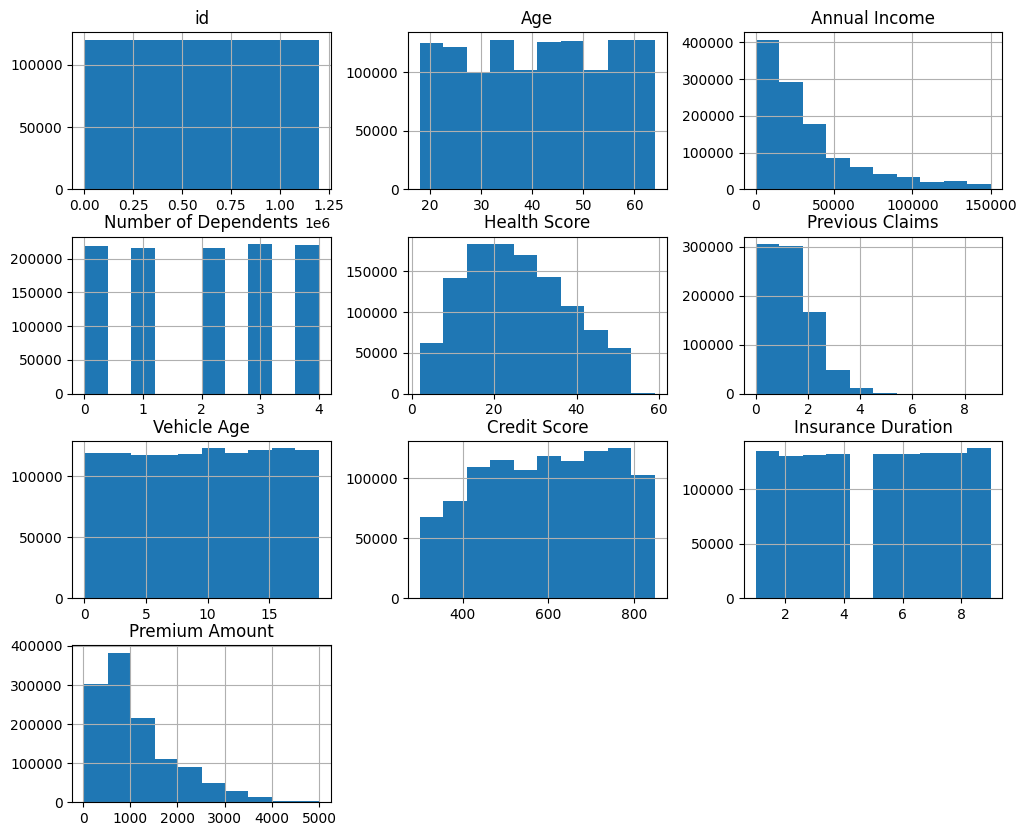

In [18]:
train_full.hist(figsize=(12,10))
        

Some general guidance that I found on handling missing values:
- For analysis, generally, above 10-20% missing values is a high percentage, depending on the dataset and goal of the analysis. However, to build a machine learning model, all missing values must be dealt with.
- If missing values in a column are more than 70% of the column's data, then deleting the column is recommended.
- If the dataset is large, then deleting rows containing null values may be appropriate. Don't delete rows, generally, if the percentage of missing values in the data is greater than 30 percent.
- It is important to consider whether the feature with missing values is important to the research question and the type of missingness that is observed when deciding how best to handle the missing values.

The goal here is to predict premium amount that the individual will have to pay.
 
All of the above columns in the training data could reasonably be expected to relate to premium amount.

Missing values will be imputed using k-NN. We need to encode categorical data into something numerical that the model can handle. I'll need to do this anyway for all the categorical features when building the machine learning model, so I'll do it for all of them now, before getting back to the correlation matrix.

Common encoding techniques:
1. One-hot encoding
    - Use with nominal (unordered) categories
    - Creates binary column for each category. 1 means present. 0 means absence.
2. Label encoding
    - Useful for ordinal categories where order is important
    - assigns unique integer to each category, starting from 0
    - can encounter problems if ordering is misinterpreted
3. Ordinal encoding
    - For ordinal variables
    - maintains order of cats while assigning numerical values
4. target encoding (mean encoding)
    - useful when relationship exists between cat variables and the target
    - replace each cat with the mean of the target var in that cat
5. binary encoding
    - useful for high-cardinality cat features (many unique vals)
    - transforms cat vars into binary representation

From the columns in the training data, the following appear to be categorical features:
- id
- Gender
- Marital Status
- Education Level
- Occupation
- Location
- Policy Type
- Policy Start Date
- Customer Feedback
- Smoking Status
- Exercise Frequency
- Property Type

In [19]:
# list all categorical features
train_cat_cols = ['id', 'Gender', 'Marital Status', 'Education Level', 
                  'Occupation', 'Location', 'Policy Type', 'Policy Start Date', 
                  'Customer Feedback', 'Smoking Status', 'Exercise Frequency', 
                  'Property Type']

In [20]:
train_full[train_cat_cols].head()

,id,Gender,Marital Status,Education Level,Occupation,Location,Policy Type,Policy Start Date,Customer Feedback,Smoking Status,Exercise Frequency,Property Type
0,0,Female,Married,Bachelor's,Self-Employed,Urban,Premium,2023-12-23 15:21:39.134960,Poor,No,Weekly,House
1,1,Female,Divorced,Master's,NaN,Rural,Comprehensive,2023-06-12 15:21:39.111551,Average,Yes,Monthly,House
2,2,Male,Divorced,High School,Self-Employed,Suburban,Premium,2023-09-30 15:21:39.221386,Good,Yes,Weekly,House
3,3,Male,Married,Bachelor's,NaN,Rural,Basic,2024-06-12 15:21:39.226954,Poor,Yes,Daily,Apartment
4,4,Male,Single,Bachelor's,Self-Employed,Rural,Premium,2021-12-01 15:21:39.252145,Poor,Yes,Weekly,House


In [21]:
# Print the unique values of each categorical variable
for i in train_cat_cols:
    print(f"Training dataset column:     {i}")
    print(f"Number of unique values:     {train_full[i].nunique()}")
    print(f"Unique values found:         {train_full[i].unique()} \n")

Training dataset column:     id
Number of unique values:     1200000
Unique values found:         [      0       1       2 ... 1199997 1199998 1199999] 

Training dataset column:     Gender
Number of unique values:     2
Unique values found:         ['Female' 'Male'] 

Training dataset column:     Marital Status
Number of unique values:     3
Unique values found:         ['Married' 'Divorced' 'Single' nan] 

Training dataset column:     Education Level
Number of unique values:     4
Unique values found:         ["Bachelor's" "Master's" 'High School' 'PhD'] 

Training dataset column:     Occupation
Number of unique values:     3
Unique values found:         ['Self-Employed' nan 'Employed' 'Unemployed'] 

Training dataset column:     Location
Number of unique values:     3
Unique values found:         ['Urban' 'Rural' 'Suburban'] 

Training dataset column:     Policy Type
Number of unique values:     3
Unique values found:         ['Premium' 'Comprehensive' 'Basic'] 

Training dataset co

In [22]:
gender_mapping = {'Female':0,
                  'Male':1}

marital_status_mapping = {'Married':2,
                          'Divorced':0,
                          'Single':1}

education_level_mapping = {"Bachelor's":1,
                           "Master's":2,
                           'High School':0,
                           'PhD':3} 

occupation_mapping = {'Self-Employed':1,
                      'Employed':2,
                      'Unemployed':0}

location_mapping = {'Urban':2,
                    'Rural':0,
                    'Suburban':1}

policy_type_mapping = {'Premium':2,
                       'Comprehensive':1,
                       'Basic':0}

customer_feedback_mapping = {'Poor':0,
                             'Average':1,
                             'Good':2}

smoking_status_mapping = {'No':0,
                          'Yes':1} 

exercise_frequency_mapping = {'Weekly':2,
                              'Monthly':1,
                              'Daily':3,
                              'Rarely':0}

property_type_mapping = {'House':2,
                         'Apartment':0,
                         'Condo':1}

list_of_mappings = {'Gender':gender_mapping,
                    'Marital Status':marital_status_mapping,
                    'Education Level':education_level_mapping,
                    'Occupation':occupation_mapping,
                    'Location':location_mapping,
                    'Policy Type':policy_type_mapping,
                    'Customer Feedback':customer_feedback_mapping,
                    'Smoking Status':smoking_status_mapping,
                    'Exercise Frequency':exercise_frequency_mapping,
                    'Property Type':property_type_mapping
                   }

# Perform ordinal encoding
train_encoded_cat_feats = train_full.copy()

for i, j in list_of_mappings.items():
    train_encoded_cat_feats[i].replace(j, inplace=True)

In [23]:
train_encoded_cat_feats.drop('Policy Start Date', inplace=True, axis=1)

In [24]:
train_encoded_cat_feats.head()

,id,Age,Gender,Annual Income,Marital Status,Number of Dependents,Education Level,Occupation,Health Score,Location,Policy Type,Previous Claims,Vehicle Age,Credit Score,Insurance Duration,Customer Feedback,Smoking Status,Exercise Frequency,Property Type,Premium Amount
0,0,19.0,0,10049.0,2.0,1.0,1,1.0,22.598761,2,2,2.0,17.0,372.0,5.0,0.0,0,2,2,2869.0
1,1,39.0,0,31678.0,0.0,3.0,2,NaN,15.569731,0,1,1.0,12.0,694.0,2.0,1.0,1,1,2,1483.0
2,2,23.0,1,25602.0,0.0,3.0,0,1.0,47.177549,1,2,1.0,14.0,NaN,3.0,2.0,1,2,2,567.0
3,3,21.0,1,141855.0,2.0,2.0,1,NaN,10.938144,0,0,1.0,0.0,367.0,1.0,0.0,1,3,0,765.0
4,4,21.0,1,39651.0,1.0,1.0,1,1.0,20.376094,0,2,0.0,8.0,598.0,4.0,0.0,1,2,2,2022.0


In [25]:
y_train_encoded_missing = train_encoded_cat_feats['Premium Amount']
x_train_encoded_missing = train_encoded_cat_feats.drop('Premium Amount', axis=1)

display(y_train_encoded_missing.head())
display(x_train_encoded_missing.head())

0    2869.0
1    1483.0
2     567.0
3     765.0
4    2022.0
Name: Premium Amount, dtype: float64

,id,Age,Gender,Annual Income,Marital Status,Number of Dependents,Education Level,Occupation,Health Score,Location,Policy Type,Previous Claims,Vehicle Age,Credit Score,Insurance Duration,Customer Feedback,Smoking Status,Exercise Frequency,Property Type
0,0,19.0,0,10049.0,2.0,1.0,1,1.0,22.598761,2,2,2.0,17.0,372.0,5.0,0.0,0,2,2
1,1,39.0,0,31678.0,0.0,3.0,2,NaN,15.569731,0,1,1.0,12.0,694.0,2.0,1.0,1,1,2
2,2,23.0,1,25602.0,0.0,3.0,0,1.0,47.177549,1,2,1.0,14.0,NaN,3.0,2.0,1,2,2
3,3,21.0,1,141855.0,2.0,2.0,1,NaN,10.938144,0,0,1.0,0.0,367.0,1.0,0.0,1,3,0
4,4,21.0,1,39651.0,1.0,1.0,1,1.0,20.376094,0,2,0.0,8.0,598.0,4.0,0.0,1,2,2


Here, I ran into an issue with the KNNImputer running forever with n_neighbors=5. This is because KNNImputer iterates through all of the data to build neighbors. I am going to try reducing the amount of data that is used before trying to run the following code again:

"""
imputer = KNNImputer(n_neighbors=5)
x_traim_imputed = imputer.fit_transform(x_train_encoded_missing)
"""

In [34]:
train_encoded_cat_feats.columns

Index(['id', 'Age', 'Gender', 'Annual Income', 'Marital Status',
       'Number of Dependents', 'Education Level', 'Occupation', 'Health Score',
       'Location', 'Policy Type', 'Previous Claims', 'Vehicle Age',
       'Credit Score', 'Insurance Duration', 'Customer Feedback',
       'Smoking Status', 'Exercise Frequency', 'Property Type',
       'Premium Amount'],
      dtype='object')

In [36]:
corr_matrix = train_encoded_cat_feats.corr()

In [ ]:
for i, j in corr_matrix.iterrows()
    print(i)
    print(j)

In [ ]:
imputer = KNNImputer(n_neighbors=5)
x_traim_imputed = imputer.fit_transform(x_train_encoded_missing)


In [ ]:
x_train_encoded_missing.head()

In [ ]:
# Write a loop to process all the records that should be encoded using one-hot encoding

ohe_columns = ['Gender', 'Marital Status', 'Occupation', 'Location', 'Smoking Status', 'Property Type', 'Policy Type']    # Create list of column names for ohe

train_encoded_dummies = pd.get_dummies(train_full, columns=ohe_columns, drop_first=True, dtype=int, dummy_na=True)

for i in train_encoded_dummies.columns:
    if '_nan' in i and train_encoded_dummies[i].value_counts().get(1,0) == 0:
        print(f'The column {i} was dropped because there are no null values')
        train_encoded_dummies.drop(i, axis=1, inplace=True)

train_encoded_dummies.head()

In [ ]:
# Identify ordinal feature values

ordinal_features = ['Education Level', 'Customer Feedback', 'Exercise Frequency']

for i in ordinal_features:
    print(f'{i} column contains the following unique values to be mapped: {train_full[i].unique()}')

In [ ]:
a['Gender', 'Marital Status', 'Occupation', 'Location', 'Smoking Status', 'Property Type', 'Policy Type']

In [ ]:
# Define the ordinal encoding mapping for Education Level
education_mapping = {
    "High School": 0,
    "Bachelor's": 1,
    "Master's": 2,
    "PhD": 3
}

# Perform ordinal encoding
train_encoded_1 = train_encoded_dummies.copy()
train_encoded_1['Education Level_Encoded'] = train_encoded_dummies['Education Level'].replace(education_mapping)
train_encoded_1.drop('Education Level', axis=1, inplace=True)
#display(train_encoded_1.head())


# Define the ordinal encoding mapping for Education Level
customer_feedback_mapping = {
    "Poor": 0,
    "Average": 1,
    "Good": 2,
}

# Perform ordinal encoding
train_encoded_2 = train_encoded_1.copy()
train_encoded_2['Customer Feedback_Encoded'] = train_encoded_2['Customer Feedback'].replace(customer_feedback_mapping)
train_encoded_2.drop('Customer Feedback', axis=1, inplace=True)
#display(train_encoded_2.head())

# Define the ordinal encoding mapping for Exercise Frequency
exercise_frequency_mapping = {
    "Rarely": 0,
    "Monthly": 1,
    "Weekly": 2,
    "Daily": 3
}

# Perform ordinal encoding
train_encoded_3 = train_encoded_2.copy()
train_encoded_3['Exercise Frequency_Encoded'] = train_encoded_3['Exercise Frequency'].replace(exercise_frequency_mapping)
train_encoded_3.drop('Exercise Frequency', axis=1, inplace=True)
train_encoded_3.head()

In [ ]:
# For now, since I dont know how to do complex datetime encoding. I'll just ignore datetime.

train_encoded_4 = train_encoded_3.drop('Policy Start Date', axis=1)
train_encoded_4.head()

In [ ]:
# Check that dtypes are correct
train_encoded_4.dtypes

In [ ]:
Impute missing values 

In [ ]:
# Create a correlation matrix for the columns with missing values
plt.matshow(train_encoded_4.corr())
plt.show()

In [ ]:
#Create a list of columns to convert to str.
str_cols = ['id','Gender','Marital Status','Education Level','Occupation','Location','Policy Type','Customer Feedback','Smoking Status','Exercise Frequency','Property Type']

#Convert these columns to str.
train_full = train_full[str_cols].astype("string")
train_full.dtypes